In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check for GPU specs
!nvidia-smi

Wed Jun 15 13:38:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/nbertagnolli/counsel-chat.git

Cloning into 'counsel-chat'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 35 (delta 11), reused 25 (delta 4), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [ ]:
!cp ./counsel-chat/utils.py .

In [ ]:
from typing import Dict, Any, Callable, List, Tuple, Optional
import dill
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from transformers import BertModel, BertTokenizer, DistilBertModel, DistilBertTokenizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import (
   CountVectorizer, TfidfVectorizer
)
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import FeatureUnion, Pipeline
import numpy as np
import torch
import re
import json

import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from scipy.sparse import csr_matrix

#from utils import *

sns.set()

from sklearn.utils.multiclass import unique_labels

In [ ]:
!pip install -q parlai
!pip install -q subword_nmt # extra requirement we need for this tutorial

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 95 kB 6.4 MB/s 
     |████████████████████████████████| 175 kB 37.7 MB/s 
     |████████████████████████████████| 248 kB 67.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 181 kB 63.4 MB/s 
     |████████████████████████████████| 64 kB 3.1 MB/s 
     |████████████████████████████████| 547 kB 67.6 MB/s 
     |████████████████████████████████| 8.9 MB 50.0 MB/s 
     |████████████████████████████████| 138 kB 73.0 MB/s 
     |████████████████████████████████| 76 kB 6.1 MB/s 
     |████████████████████████████████| 125 kB 78.9 MB/s 
     |████████████████████████████████| 132 kB 71.0 MB/s 
     |████████████████████████████████| 147 kB 76.4 MB/s 
     |████████████████████████████████| 235 kB 74.8 MB/s 
     |████████████████████

In [ ]:
# Import the Interactive script
from parlai.scripts.interactive import Interactive

# The display_data script is used to show the contents of a particular task.
# By default, shows train set
from parlai.scripts.display_data import DisplayData

# Script for training model
from parlai.scripts.train_model import TrainModel

# Visualize model prediction
from parlai.scripts.display_model import DisplayModel

In [ ]:
df = pd.read_csv("./counsel-chat/data/20200325_counsel_chat.csv", encoding='utf-8')
df.head()

,Unnamed: 0,questionID,questionTitle,questionText,questionLink,topic,therapistInfo,therapistURL,answerText,upvotes,views,split
0,0,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,"Sherry Katz, LCSWCouples and Family Therapist,...",https://counselchat.com/therapists/sherry-katz...,"If everyone thinks you're worthless, then mayb...",1,2899,train
1,1,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,"Robin Landwehr, DBH, LPCC, NCCMental Health in...",https://counselchat.com/therapists/robin-landw...,"Hello, and thank you for your question and see...",1,3514,train
2,2,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,Lee KingI use an integrative approach to treat...,https://counselchat.com/therapists/lee-king,First thing I'd suggest is getting the sleep y...,0,5,train
3,3,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,"Shauntai Davis-YearginPersonalized, private on...",https://counselchat.com/therapists/shauntai-da...,Therapy is essential for those that are feelin...,0,31,train
4,4,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,Jordan WhiteLicensed Social Worker at Oak Root...,https://counselchat.com/therapists/jordan-white,I first want to let you know that you are not ...,0,620,train


## Descriptive statistics

In [ ]:
# Number of Topics
len(set(df["topic"].tolist()))

31

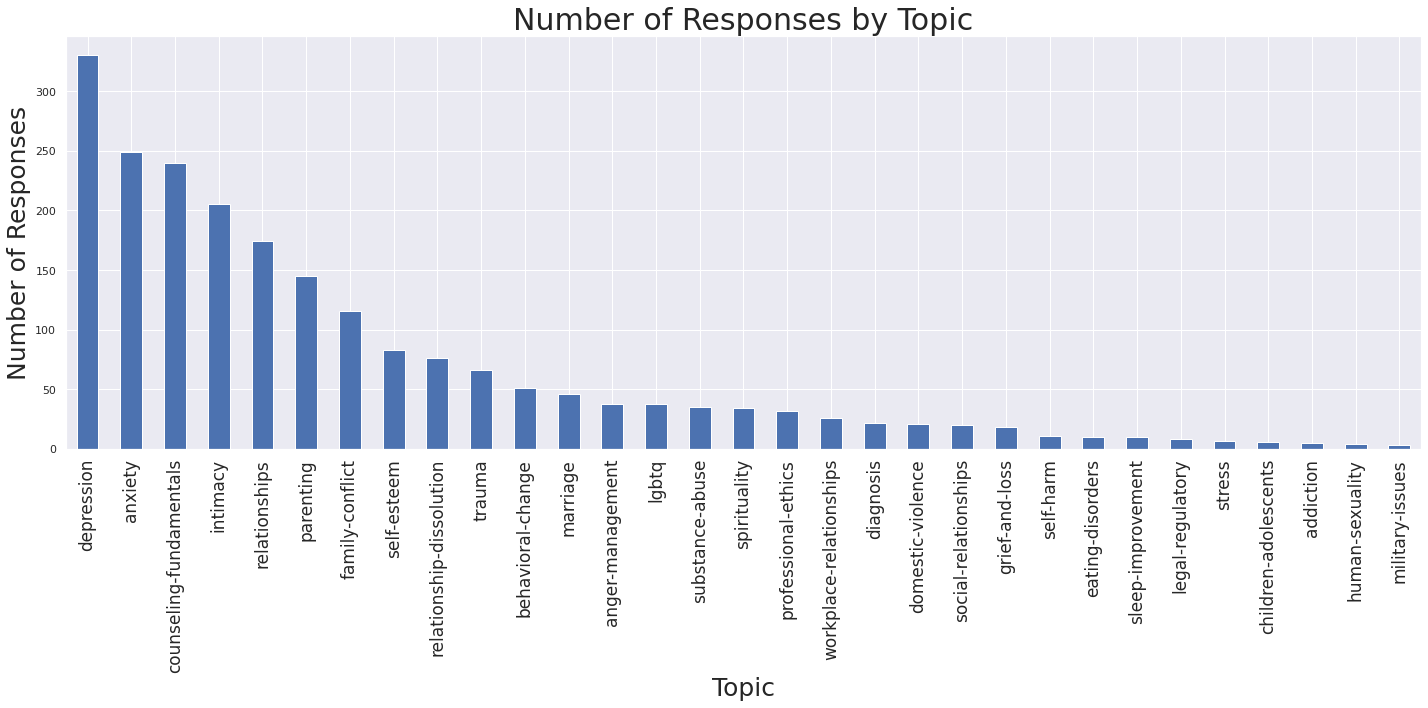

In [ ]:
# Distribution of answers by topic
fig, ax = plt.subplots(figsize=(20, 10))
df.groupby("topic").agg("count")["questionID"].sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Number of Responses by Topic", fontsize=30)
ax.set_xlabel("Topic", fontsize=25)
ax.set_ylabel("Number of Responses", fontsize=25)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=17)
plt.tight_layout()
#plt.savefig("./responses_by_topics_count.png")

Topic: 
* depression
* anxiety
* trauma
* self-harm
* eating-disorders

In [ ]:
sub_df = df.loc[(df['topic'] == 'depression') | (df['topic'] == 'anxiety') | (df['topic'] == 'trauma') | (df['topic'] == 'self-harm') | (df['topic'] == 'eating-disorders')].drop(['Unnamed: 0','questionTitle','questionLink','therapistInfo','therapistURL','upvotes','views'],axis=1).reset_index().drop(['index'],axis=1)

In [ ]:
sub_df.to_csv('./counsel_chat_subset.csv',index=False)

In [ ]:
sub_df

,questionID,questionText,topic,answerText,split
0,0,I'm going through some things with my feelings...,depression,"If everyone thinks you're worthless, then mayb...",train
1,0,I'm going through some things with my feelings...,depression,"Hello, and thank you for your question and see...",train
2,0,I'm going through some things with my feelings...,depression,First thing I'd suggest is getting the sleep y...,train
3,0,I'm going through some things with my feelings...,depression,Therapy is essential for those that are feelin...,train
4,0,I'm going through some things with my feelings...,depression,I first want to let you know that you are not ...,train
...,...,...,...,...,...
661,2,After he got home from the hospital he was ang...,self-harm,I appreciate that you are concerned about your...,train
662,2,After he got home from the hospital he was ang...,self-harm,A failed suicide attempt is commonly thought o...,train
663,2,After he got home from the hospital he was ang...,self-harm,The fact that you're reaching out for help her...,train
664,2,After he got home from the hospital he was ang...,self-harm,Since as husband and wife your lives are close...,train


In [ ]:
sub_df['topic'].unique()

array(['depression', 'anxiety', 'trauma', 'eating-disorders', 'self-harm'],
      dtype=object)

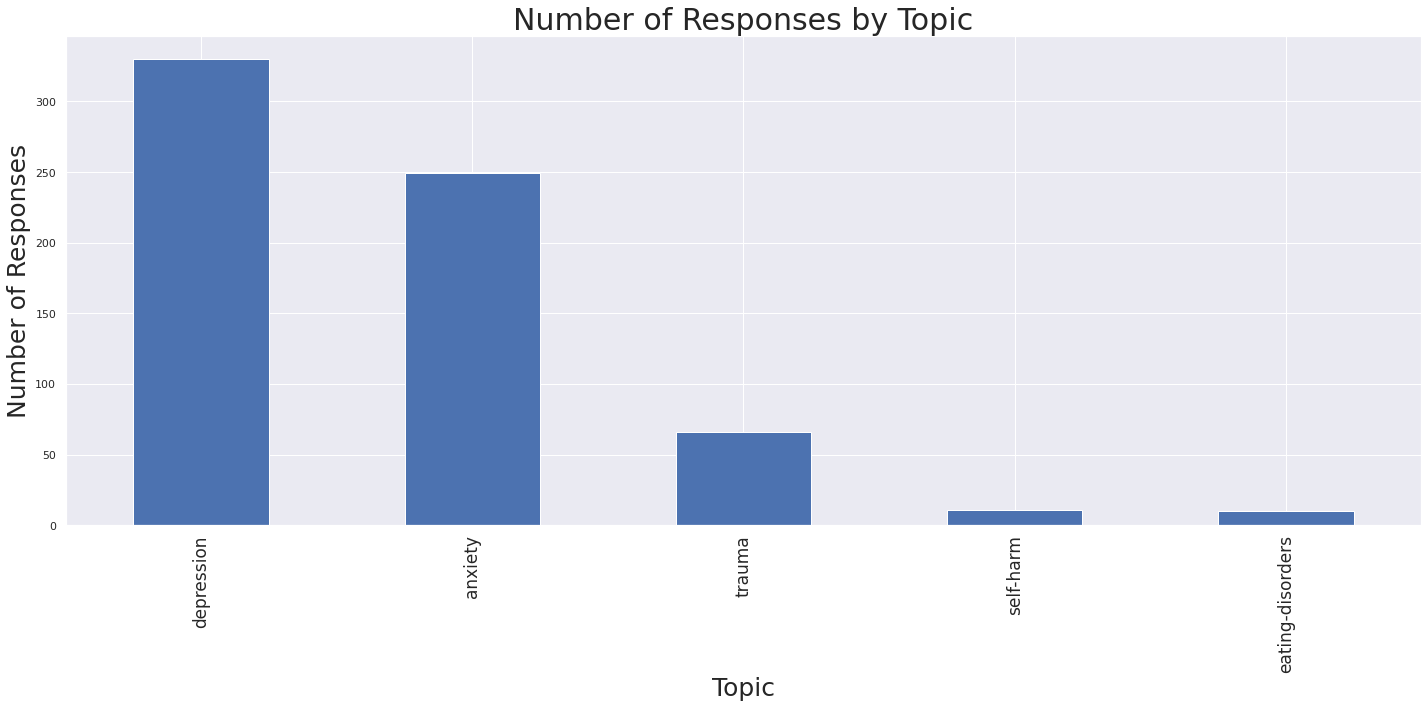

In [ ]:
# Distribution of answers by topic
fig, ax = plt.subplots(figsize=(20, 10))
sub_df.groupby("topic").agg("count")['questionID'].sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Number of Responses by Topic", fontsize=30)
ax.set_xlabel("Topic", fontsize=25)
ax.set_ylabel("Number of Responses", fontsize=25)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=17)
plt.tight_layout()
plt.savefig("./responses_by_topics_count.png")

In [ ]:
len(sub_df['questionText'].unique())

246

## Customize counselchat dataset

In [ ]:
from parlai.core.teachers import register_teacher, DialogTeacher

In [ ]:
for x in range(20):
  print(x, sub_df['answerText'][x])

0 If everyone thinks you're worthless, then maybe you need to find new people to hang out with.Seriously, the social context in which a person lives is a big influence in self-esteem.Otherwise, you can go round and round trying to understand why you're not worthless, then go back to the same crowd and be knocked down again.There are many inspirational messages you can find in social media.  Maybe read some of the ones which state that no person is worthless, and that everyone has a good purpose to their life.Also, since our culture is so saturated with the belief that if someone doesn't feel good about themselves that this is somehow terrible.Bad feelings are part of living.  They are the motivation to remove ourselves from situations and relationships which do us more harm than good.Bad feelings do feel terrible.   Your feeling of worthlessness may be good in the sense of motivating you to find out that you are much better than your feelings today.
1 Hello, and thank you for your ques

In [ ]:
len(sub_df)

666

In [ ]:
sub_df = pd.read_csv('/content/drive/MyDrive/Mental_health_chatbot/data/counsel_chat_subset_small.csv')

In [ ]:
sub_df['topic'].unique()

array(['depression', 'anxiety', 'trauma', 'eating-disorders', 'self-harm'],
      dtype=object)

In [ ]:
len(sub_df[sub_df['topic'] == 'depression']['questionText'].unique())

159

In [ ]:
sub_df[sub_df['topic'] == 'depression']['questionText'].unique()

array(["I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.\n   How can I change my feeling of being worthless to everyone?",
       'I have so many issues to address. I have a history of sexual abuse, I’m a breast cancer survivor and I am a lifetime insomniac.    I have a long history of depression and I’m beginning to have anxiety. I have low self esteem but I’ve been happily married for almost 35 years.\n   I’ve never had counseling about any of this. Do I have too many issues to address in counseling?',
       'I have been feeling more and more down for over a month. I have started having trouble sleeping due to panic attacks, but they are almost never triggered by something that I know of.',
       'I’m facing severe depression and anxiety and I just feel like I’m going

In [ ]:
len(sub_df[sub_df['topic'] == 'depression']['answerText'].unique())

160

In [ ]:
from iopath.common.file_io import PathManager
@register_teacher('counselchat')
class CounselChat(DialogTeacher):
    def __init__(self, opt, shared=None):
        # opt is the command line arguments.
        # What is this shared thing?
        # We make many copies of a teacher, one-per-batchsize. Shared lets us store 
        
        # We just need to set the "datafile".  This is boilerplate, but differs in many teachers.
        # The "datafile" is the filename where we will load the data from. In this case, we'll set it to
        # the fold name (train/valid/test) + ".txt"
        opt['datafile'] = opt['datatype'].split(':')[0] + ".txt"
        #print("this is",opt['datafile'])
        super().__init__(opt, shared)
    
    def setup_data(self, path):
        # filename tells us where to load from.
        # We'll just use some hardcoded data, but show how you could read the filename here:
        print(f" ~~ Loading from {path} ~~ ")
        
        self.counsel = pd.read_csv('/content/drive/MyDrive/Mental_health_chatbot/data/counsel_chat_subset_small.csv')

        # # Each row is a context for the attached questions
  



        for x in range(len(self.counsel)):
           question = self.counsel['questionText'][x]
           answer = self.counsel['answerText'][x]
           yield {"text": question, "labels": answer}, True




In [ ]:
DisplayData.main(task="counselchat")

13:41:44 | Opt:
13:41:44 |     allow_missing_init_opts: False
13:41:44 |     batchsize: 1
13:41:44 |     datapath: /usr/local/lib/python3.7/dist-packages/data
13:41:44 |     datatype: train:ordered
13:41:44 |     dict_class: None
13:41:44 |     display_add_fields: 
13:41:44 |     download_path: None
13:41:44 |     dynamic_batching: None
13:41:44 |     hide_labels: False
13:41:44 |     ignore_agent_reply: True
13:41:44 |     image_cropsize: 224
13:41:44 |     image_mode: raw
13:41:44 |     image_size: 256
13:41:44 |     init_model: None
13:41:44 |     init_opt: None
13:41:44 |     is_debug: False
13:41:44 |     loglevel: info
13:41:44 |     max_display_len: 1000
13:41:44 |     model: None
13:41:44 |     model_file: None
13:41:44 |     multitask_weights: [1]
13:41:44 |     mutators: None
13:41:44 |     num_examples: 10
13:41:44 |     override: "{'task': 'counselchat'}"
13:41:44 |     parlai_home: /usr/local/lib/python3.7/dist-packages
13:41:44 |     starttime: Jun15_13-41
13:41:44 |     

In [ ]:
DisplayModel.main(task='personachat', datapath='./content/data',
                  model_file='from_pretrained/model', skip_generation=False)

00:19:33 | loading dictionary from from_pretrained/model.dict
00:19:33 | num words = 54946
00:19:35 | Total parameters: 88,559,104 (88,559,104 trainable)
00:19:35 | Loading existing model params from from_pretrained/model
00:19:35 | creating task(s): personachat
[building data: ./content/data/Persona-Chat]
00:19:36 | Downloading http://parl.ai/downloads/personachat/personachat.tgz to ./content/data/Persona-Chat/personachat.tgz


00:20:00 | loading fbdialog data: ./content/data/Persona-Chat/personachat/valid_self_original.txt
00:20:01 | Opt:
00:20:01 |     activation: gelu
00:20:01 |     adafactor_eps: '[1e-30, 0.001]'
00:20:01 |     adam_eps: 1e-08
00:20:01 |     add_p1_after_newln: False
00:20:01 |     aggregate_micro: False
00:20:01 |     allow_missing_init_opts: False
00:20:01 |     attention_dropout: 0.0
00:20:01 |     batchsize: 16
00:20:01 |     beam_block_full_context: True
00:20:01 |     beam_block_list_filename: None
00:20:01 |     beam_block_ngram: -1
00:20:01 |     beam_context_block_ngram: -1
00:20:01 |     beam_delay: 30
00:20:01 |     beam_length_penalty: 0.65
00:20:01 |     beam_min_length: 1
00:20:01 |     beam_size: 1
00:20:01 |     betas: '[0.9, 0.999]'
00:20:01 |     bpe_add_prefix_space: None
00:20:01 |     bpe_debug: False
00:20:01 |     bpe_dropout: None
00:20:01 |     bpe_merge: None
00:20:01 |     bpe_vocab: None
00:20:01 |     checkpoint_activations: False
00:20:01 |     compute_tokeni

## Fine tune on counsel chat dataset

In [ ]:
!rm -rf image_seq2seq_counselchat
!mkdir -p image_seq2seq_counselchat

### Image_seq2seq 

In [ ]:
print(TrainModel.help(model='image_seq2seq'))

usage: TrainModel [-h] [--helpall] [-o INIT_OPT]
                  [--allow-missing-init-opts ALLOW_MISSING_INIT_OPTS]
                  [-t TASK] [-dt DATATYPE] [-bs BATCHSIZE]
                  [-dynb {full,None,batchsort}] [-v] [--debug] [-dp DATAPATH]
                  [-m MODEL] [-mf MODEL_FILE] [-im INIT_MODEL] [-et EVALTASK]
                  [--final-extra-opt FINAL_EXTRA_OPT]
                  [--eval-dynamic-batching {off,full,None,batchsort}]
                  [--num-workers NUM_WORKERS] [-eps NUM_EPOCHS]
                  [-ttim MAX_TRAIN_TIME] [-tstep MAX_TRAIN_STEPS]
                  [-lstep LOG_EVERY_N_STEPS] [-vtim VALIDATION_EVERY_N_SECS]
                  [-vstep VALIDATION_EVERY_N_STEPS] [-stim SAVE_EVERY_N_SECS]
                  [-sval SAVE_AFTER_VALID] [-veps VALIDATION_EVERY_N_EPOCHS]
                  [-vp VALIDATION_PATIENCE] [-vmt VALIDATION_METRIC]
                  [-vmm {max,min}] [-mcs METRICS] [-micro AGGREGATE_MICRO]
                  [--world-logs WORL

In [ ]:
# Improvement using transfer learning
TrainModel.main(
    # similar to before
    task='counselchat,personachat', 
    datapath='./data',

    # model argument
    model='image_seq2seq',
    model_file='image_seq2seq_counselchat/model',

    max_train_time=60*10,
    

    
    # initialize with a pretrained model
    init_model='zoo:dodecadialogue/empathetic_dialogues_ft/model', # which pretrained model you want to use
    dict_file = 'zoo:dodecadialogue/empathetic_dialogues_ft/model.dict', # where to find the pretrained model dictionary

    batchsize=16,
    embedding_size=512,
    n_layers=8,
    learn_positional_embeddings=True,
    embeddings_scale=True,
    n_positions=512,
    variant='xlm',
    n_heads=16,
    image_features_dim=2048,
    text_truncate=512,
    label_truncate=128,
    ffn_size=2048,
    activation='gelu',
    share_word_embeddings=True,
    dict_tokenizer="bpe",
    load_from_checkpoint=True,


)

05:59:53 | building dictionary first...
05:59:53 | No model with opt yet at: image_seq2seq_counselchat/model(.opt)
05:59:53 | your model is being loaded with opts that do not exist in the model you are initializing the weights with: allow_missing_init_opts: False,download_path: None,loglevel: info,dynamic_batching: None,verbose: False,is_debug: False,datapath: ./data,final_extra_opt: ,eval_dynamic_batching: None,num_workers: 0,max_train_steps: -1,log_every_n_steps: 50,validation_every_n_steps: -1,load_from_checkpoint: True,world_logs: ,save_format: conversations,log_keep_fields: all,tensorboard_logdir: None,wandb_log: False,wandb_name: None,wandb_project: None,wandb_entity: None,image_size: 256,image_cropsize: 224,mutators: None,n_encoder_layers: -1,n_decoder_layers: -1,model_parallel: False,checkpoint_activations: False,beam_context_block_ngram: -1,beam_block_ngram: -1,beam_block_full_context: True,beam_length_penalty: 0.65,beam_delay: 30,beam_block_list_filename: None,temperature: 1.

({'accuracy': MacroAverageMetric(0.0001282),
  'bleu-4': MacroAverageMetric(0.01692),
  'clen': MacroAverageMetric(112.6),
  'counselchat/accuracy': ExactMatchMetric(0),
  'counselchat/bleu-4': BleuMetric(0.02283),
  'counselchat/clen': AverageMetric(68.56),
  'counselchat/ctrunc': AverageMetric(0),
  'counselchat/ctrunclen': AverageMetric(0),
  'counselchat/exs': SumMetric(288),
  'counselchat/f1': F1Metric(0.2203),
  'counselchat/gen_n_toks': AverageMetric(128.1),
  'counselchat/llen': AverageMetric(236.4),
  'counselchat/loss': AverageMetric(0.674),
  'counselchat/ltrunc': AverageMetric(0.7361),
  'counselchat/ltrunclen': AverageMetric(117.1),
  'counselchat/ppl': PPLMetric(1.962),
  'counselchat/token_acc': AverageMetric(0.8569),
  'counselchat/token_em': AverageMetric(0),
  'ctpb': GlobalAverageMetric(1113),
  'ctps': GlobalTimerMetric(533.5),
  'ctrunc': MacroAverageMetric(0),
  'ctrunclen': MacroAverageMetric(0),
  'exps': GlobalTimerMetric(7.67),
  'exs': SumMetric(8089),
  'f1

In [ ]:
!zip -r ./image_seq2seq_counselchat.zip /content/image_seq2seq_counselchat

  adding: content/image_seq2seq_counselchat/ (stored 0%)
  adding: content/image_seq2seq_counselchat/model.opt (deflated 66%)
  adding: content/image_seq2seq_counselchat/model.test (deflated 58%)
  adding: content/image_seq2seq_counselchat/model.dict (deflated 55%)
  adding: content/image_seq2seq_counselchat/model (deflated 8%)
  adding: content/image_seq2seq_counselchat/model.dict.codecs (deflated 64%)
  adding: content/image_seq2seq_counselchat/model.dict.opt (deflated 69%)
  adding: content/image_seq2seq_counselchat/model.valid (deflated 59%)
  adding: content/image_seq2seq_counselchat/model.trainstats (deflated 81%)


### Transformer

In [ ]:
!rm -rf transformer_counselchat
!mkdir -p transformer_counselchat

In [ ]:
!rm -rf transformer_counselchat_v2
!mkdir -p transformer_counselchat_v2

In [ ]:
TrainModel.main(
    # similar to before
    task='counselchat,convai2,empathetic_dialogues,saferdialogues,blended_skill_talk', 
    model='transformer/generator',
    model_file='transformer_counselchat_v2/model',
    
    # initialize with a pretrained model
    init_model='zoo:tutorial_transformer_generator/model',
    
    # arguments we get from the pretrained model.
    # Unfortunately, these must be looked up separately for each model.
    n_heads=16, n_layers=8, n_positions=512, text_truncate=512,
    label_truncate=128, ffn_size=2048, embedding_size=512,
    activation='gelu', variant='xlm',
    dict_lower=True, dict_tokenizer='bpe',
    dict_file='zoo:tutorial_transformer_generator/model.dict',
    learn_positional_embeddings=True,
    
    # some training arguments, specific to this fine-tuning
    # use a small learning rate with ADAM optimizer
    lr=1e-5, optimizer='adam',
    warmup_updates=100,
    # early stopping on perplexity
    validation_metric='ppl',
    # train at most 10 minutes, and validate every 0.25 epochs
    max_train_time=60*30, validation_every_n_epochs=0.25,
    
    # depend on your gpu. If you have a V100, this is good
    batchsize=12, fp16=True, fp16_impl='mem_efficient',
    
    # speeds up validation
    skip_generation=True,
    
    # helps us cram more examples into our gpu at a time
    dynamic_batching='full',
)

14:59:17 | building data: ./data/models/tutorial_transformer_generator/tutorial_transformer_generator_v1.tar.gz
14:59:17 | Downloading http://parl.ai/downloads/_models/tutorial_transformer_generator/tutorial_transformer_generator_v1.tar.gz to ./data/models/tutorial_transformer_generator/tutorial_transformer_generator_v1.tar.gz


14:59:58 | building dictionary first...
14:59:58 | No model with opt yet at: transformer_counselchat_v2/model(.opt)
14:59:58 | your model is being loaded with opts that do not exist in the model you are initializing the weights with: allow_missing_init_opts: False,download_path: None,loglevel: info,dynamic_batching: full,verbose: False,is_debug: False,datapath: ./data,final_extra_opt: ,eval_dynamic_batching: None,num_workers: 0,max_train_steps: -1,log_every_n_steps: 50,validation_every_n_steps: -1,load_from_checkpoint: True,world_logs: ,save_format: conversations,log_keep_fields: all,tensorboard_logdir: None,wandb_log: False,wandb_name: None,wandb_project: None,wandb_entity: None,train_experiencer_only: False,recovery: True,mutators: None,n_encoder_layers: -1,n_decoder_layers: -1,model_parallel: False,checkpoint_activations: False,beam_block_full_context: True,beam_length_penalty: 0.65,topk: 10,topp: 0.9,beam_delay: 30,beam_block_list_filename: None,temperature: 1.0,compute_tokenized_b

15:00:30 | loading fbdialog data: ./data/ConvAI2/train_self_original.txt
[building data: ./data/empatheticdialogues]
15:00:33 | Downloading http://parl.ai/downloads/empatheticdialogues/empatheticdialogues.tar.gz to ./data/empatheticdialogues/empatheticdialogues.tar.gz


[building data: ./data/saferdialogues]
15:00:36 | Downloading http://parl.ai/downloads/saferdialogues/saferdialogues_v0.1.tar.gz to ./data/saferdialogues/saferdialogues_v0.1.tar.gz


15:00:37 | Loading ParlAI text data: ./data/saferdialogues/saferdialogues_dataset/train.txt
[building data: ./data/blended_skill_talk]
15:00:37 | Downloading http://parl.ai/downloads/blended_skill_talk/blended_skill_talk.tar.gz to ./data/blended_skill_talk/blended_skill_talk.tar.gz


15:00:40 | Downloading http://parl.ai/downloads/blended_skill_talk/personas_list.txt to ./data/blended_skill_talk/persona_list.txt


15:00:41 | Downloading http://parl.ai/downloads/blended_skill_talk/topic_to_persona_list.txt to ./data/blended_skill_talk/topic_to_persona_list.txt


15:00:42 | Downloading http://parl.ai/downloads/blended_skill_talk/ed_persona_topicifier__train__both_sides.json to ./data/blended_skill_talk/ed_persona_topicifier__train__both_sides.json


15:00:44 | Downloading http://parl.ai/downloads/blended_skill_talk/ed_persona_topicifier__train__experiencer_only.json to ./data/blended_skill_talk/ed_persona_topicifier__train__experiencer_only.json


15:00:48 | Downloading http://parl.ai/downloads/blended_skill_talk/ed_persona_topicifier__valid__experiencer_only.json to ./data/blended_skill_talk/ed_persona_topicifier__valid__experiencer_only.json


15:00:52 | Downloading http://parl.ai/downloads/blended_skill_talk/ed_persona_topicifier__test__experiencer_only.json to ./data/blended_skill_talk/ed_persona_topicifier__test__experiencer_only.json


15:00:55 | Downloading http://parl.ai/downloads/blended_skill_talk/safe_personas_2.txt to ./data/blended_skill_talk/safe_personas.txt


15:00:56 | Downloading http://parl.ai/downloads/blended_skill_talk/human_annotations.json to ./data/blended_skill_talk/human_annotations.json


Loading ./data/blended_skill_talk/train.json.
Saving to ./data/blended_skill_talk/train.txt
Loading ./data/blended_skill_talk/valid.json.
Saving to ./data/blended_skill_talk/valid.txt
Loading ./data/blended_skill_talk/test.json.
Saving to ./data/blended_skill_talk/test.txt
15:01:00 | Loading ParlAI text data: ./data/blended_skill_talk/train.txt
15:01:10 | training...
15:01:12 | Overflow: setting loss scale to 65536.0
15:01:32 | time:22s total_exs:2320 total_steps:50 epochs:0.01
                         clen  clip  ctpb  ctps  ctrunc  ctrunclen  exps  exs  fp16_loss_scalar  gnorm  gpu_mem  llen  loss  \
   all                  73.71 .9800  3476  8409       0          0 112.2 2320             65536  5.656    .5169 54.07  2.91   
   blended_skill_talk   104.2                         0          0        437                                   17.96 2.824   
   convai2               84.5                         0          0        547                                   12.88 2.949   
   counse

({'blended_skill_talk/clen': AverageMetric(162.7),
  'blended_skill_talk/ctrunc': AverageMetric(0),
  'blended_skill_talk/ctrunclen': AverageMetric(0),
  'blended_skill_talk/exs': SumMetric(5651),
  'blended_skill_talk/llen': AverageMetric(18.14),
  'blended_skill_talk/loss': AverageMetric(2.789),
  'blended_skill_talk/ltrunc': AverageMetric(0),
  'blended_skill_talk/ltrunclen': AverageMetric(0),
  'blended_skill_talk/ppl': PPLMetric(16.26),
  'blended_skill_talk/token_acc': AverageMetric(0.4129),
  'blended_skill_talk/token_em': AverageMetric(0.0003539),
  'clen': MacroAverageMetric(105.4),
  'convai2/clen': AverageMetric(159.3),
  'convai2/ctrunc': AverageMetric(0),
  'convai2/ctrunclen': AverageMetric(0),
  'convai2/exs': SumMetric(7801),
  'convai2/llen': AverageMetric(13.66),
  'convai2/loss': AverageMetric(2.615),
  'convai2/ltrunc': AverageMetric(0),
  'convai2/ltrunclen': AverageMetric(0),
  'convai2/ppl': PPLMetric(13.66),
  'convai2/token_acc': AverageMetric(0.4421),
  'conva

## Model prediction

### Image_seq2seq

In [ ]:
from parlai.scripts.display_model import DisplayModel
DisplayModel.main(
    datapath = './data',
    task='counselchat',
    model_file='/content/image_seq2seq_counselchat/model',
    num_examples=30,
   # skip_generation=False,
)

06:23:22 | Overriding opt["task"] to counselchat (previously: counselchat,personachat)
06:23:22 | Overriding opt["model_file"] to /content/image_seq2seq_counselchat/model (previously: image_seq2seq_counselchat/model)
06:23:22 | Using CUDA
06:23:22 | loading dictionary from /content/image_seq2seq_counselchat/model.dict
06:23:22 | num words = 54946
06:23:25 | Total parameters: 88,559,104 (88,559,104 trainable)
06:23:25 | Loading existing model params from /content/image_seq2seq_counselchat/model
06:23:25 | creating task(s): counselchat
 ~~ Loading from valid.txt ~~ 
06:23:25 | Opt:
06:23:25 |     activation: gelu
06:23:25 |     adafactor_eps: '[1e-30, 0.001]'
06:23:25 |     adam_eps: 1e-08
06:23:25 |     add_p1_after_newln: False
06:23:25 |     aggregate_micro: False
06:23:25 |     allow_missing_init_opts: False
06:23:25 |     attention_dropout: 0.0
06:23:25 |     batchsize: 16
06:23:25 |     beam_block_full_context: True
06:23:25 |     beam_block_list_filename: None
06:23:25 |     beam_

### Transformer

In [ ]:
from parlai.scripts.display_model import DisplayModel
DisplayModel.main(
    datapath = './data',
    task='counselchat',
    model_file='/content/transformer_counselchat_v2/model',
    num_examples=30,
    skip_generation=False,
)

15:45:41 | Overriding opt["task"] to counselchat (previously: counselchat,convai2,empathetic_dialogues,saferdialogues,blended_skill_talk)
15:45:41 | Overriding opt["model_file"] to /content/transformer_counselchat_v2/model (previously: transformer_counselchat_v2/model)
15:45:41 | Overriding opt["skip_generation"] to False (previously: True)
15:45:41 | Using CUDA
15:45:41 | loading dictionary from /content/transformer_counselchat_v2/model.dict
15:45:41 | num words = 54944
15:45:43 | Total parameters: 87,508,992 (87,508,992 trainable)
15:45:43 | Loading existing model params from /content/transformer_counselchat_v2/model
15:45:45 | creating task(s): counselchat
 ~~ Loading from valid.txt ~~ 
15:45:45 | Opt:
15:45:45 |     activation: gelu
15:45:45 |     adafactor_eps: '[1e-30, 0.001]'
15:45:45 |     adam_eps: 1e-08
15:45:45 |     add_p1_after_newln: False
15:45:45 |     aggregate_micro: False
15:45:45 |     allow_missing_init_opts: False
15:45:45 |     attention_dropout: 0.0
15:45:45 |  

In [ ]:
!zip -r ./transformer_counselchat_v2.zip /content/transformer_counselchat_v2

  adding: content/transformer_counselchat_v2/ (stored 0%)
  adding: content/transformer_counselchat_v2/model.opt (deflated 66%)
  adding: content/transformer_counselchat_v2/model.test (deflated 69%)
  adding: content/transformer_counselchat_v2/model.dict (deflated 55%)
  adding: content/transformer_counselchat_v2/model (deflated 21%)
  adding: content/transformer_counselchat_v2/model.dict.codecs (deflated 64%)
  adding: content/transformer_counselchat_v2/model.dict.opt (deflated 69%)
  adding: content/transformer_counselchat_v2/model.valid (deflated 69%)
  adding: content/transformer_counselchat_v2/model.trainstats (deflated 84%)


In [ ]:
from parlai.scripts.display_model import DisplayModel
DisplayModel.main(
    datapath = './data',
    task='counselchat',
    model_file='/content/drive/MyDrive/Mental_health_chatbot/Models/Chatbot models/transformer_counselchat_v2/model',
    num_examples=30,
    skip_generation=False,
)

15:55:31 | Overriding opt["task"] to counselchat (previously: counselchat,convai2,empathetic_dialogues,saferdialogues,blended_skill_talk)
15:55:31 | Overriding opt["model_file"] to /content/drive/MyDrive/Mental_health_chatbot/Models/Chatbot models/transformer_counselchat_v2/model (previously: transformer_counselchat_v2/model)
15:55:31 | Overriding opt["skip_generation"] to False (previously: True)
15:55:31 | Using CUDA
15:55:31 | loading dictionary from /content/drive/MyDrive/Mental_health_chatbot/Models/Chatbot models/transformer_counselchat_v2/model.dict
15:55:31 | num words = 54944
15:55:32 | Total parameters: 87,508,992 (87,508,992 trainable)
15:55:32 | Loading existing model params from /content/drive/MyDrive/Mental_health_chatbot/Models/Chatbot models/transformer_counselchat_v2/model
15:55:36 | creating task(s): counselchat
 ~~ Loading from valid.txt ~~ 
15:55:37 | Opt:
15:55:37 |     activation: gelu
15:55:37 |     adafactor_eps: '[1e-30, 0.001]'
15:55:37 |     adam_eps: 1e-08
1

## Interactive model testing

#### Image_seq2seq

In [ ]:
# call it with particular args
Interactive.main(
    # the model_file is a filename path pointing to a particular model dump.
    # Model files that begin with "zoo:" are special files distributed by the ParlAI team.
    # They'll be automatically downloaded when you ask to use them.
    model_file='/content/image_seq2seq_counselchat/model',
    inference='beam',
    beam_size= 3,
    beam_min_length= 10,
    beam_block_ngram= 3,
    beam_context_block_ngram= 3,
)

06:25:27 | Overriding opt["model_file"] to /content/image_seq2seq_counselchat/model (previously: image_seq2seq_counselchat/model)
06:25:27 | Overriding opt["inference"] to beam (previously: greedy)
06:25:27 | Overriding opt["beam_size"] to 3 (previously: 1)
06:25:27 | Overriding opt["beam_min_length"] to 10 (previously: 1)
06:25:27 | Overriding opt["beam_block_ngram"] to 3 (previously: -1)
06:25:27 | Overriding opt["beam_context_block_ngram"] to 3 (previously: -1)
06:25:27 | Using CUDA
06:25:27 | loading dictionary from /content/image_seq2seq_counselchat/model.dict
06:25:27 | num words = 54946
06:25:28 | ImageSeq2seq: full interactive mode on.
06:25:29 | Total parameters: 88,559,104 (88,559,104 trainable)
06:25:29 | Loading existing model params from /content/image_seq2seq_counselchat/model
06:25:30 | Opt:
06:25:30 |     activation: gelu
06:25:30 |     adafactor_eps: '[1e-30, 0.001]'
06:25:30 |     adam_eps: 1e-08
06:25:30 |     add_p1_after_newln: False
06:25:30 |     aggregate_micro:

/usr/local/lib/python3.7/dist-packages/parlai/core/torch_generator_agent.py:1728: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  hyp_ids = best_idxs // voc_size


[ImageSeq2seq]: __unk__ t sounds like you are feeling very unsure about what you are doing with your life . __unk__ t is possible that you lost your identity because you were not with your family when you were younger . __unk__ f you are so unsure about who you are as a person , then you may be able to look at what you have lost and make a list of all the people who have lost their identity .
Enter Your Message: I feel like I took upon a parent role when I'm the second youngest, and I'm not stable
[ImageSeq2seq]: __unk__ f there is no way to know whether you lost identity or not , it would be a good idea to talk with a local mental health agency to see if they can work with you on what you would like to do with your identity . __unk__ irst of all , __unk__ can ' t help you there , but __unk__ hope you reach out to someone because __unk__ f __unk__ __unk__ __unk__ can help you decide whether you want to look for a different identity in your life or not . __unk__ nfortunately , __unk__ t

### Transformer

### v_1

In [ ]:
# call it with particular args
Interactive.main(
    # the model_file is a filename path pointing to a particular model dump.
    # Model files that begin with "zoo:" are special files distributed by the ParlAI team.
    # They'll be automatically downloaded when you ask to use them.
    model_file='/content/transformer_counselchat/model',
    inference='beam',
    beam_size= 3,
    beam_min_length= 10,
    beam_block_ngram= 3,
    beam_context_block_ngram= 3,
)

14:19:32 | Overriding opt["model_file"] to /content/transformer_counselchat/model (previously: transformer_counselchat/model)
14:19:32 | Overriding opt["inference"] to beam (previously: greedy)
14:19:32 | Overriding opt["beam_size"] to 3 (previously: 1)
14:19:32 | Overriding opt["beam_min_length"] to 10 (previously: 1)
14:19:32 | Overriding opt["beam_block_ngram"] to 3 (previously: -1)
14:19:32 | Overriding opt["beam_context_block_ngram"] to 3 (previously: -1)
14:19:32 | Using CUDA
14:19:32 | loading dictionary from /content/transformer_counselchat/model.dict
14:19:33 | num words = 54944
14:19:33 | TransformerGenerator: full interactive mode on.
14:19:34 | Total parameters: 87,508,992 (87,508,992 trainable)
14:19:34 | Loading existing model params from /content/transformer_counselchat/model
14:19:35 | Opt:
14:19:35 |     activation: gelu
14:19:35 |     adafactor_eps: '[1e-30, 0.001]'
14:19:35 |     adam_eps: 1e-08
14:19:35 |     add_p1_after_newln: False
14:19:35 |     aggregate_micro:

/usr/local/lib/python3.7/dist-packages/parlai/core/torch_generator_agent.py:1728: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  hyp_ids = best_idxs // voc_size


[TransformerGenerator]: i ' m so sorry to hear that . i hope you feel better soon .
Enter Your Message: I'm facing severe depression
[TransformerGenerator]: i am so sorry that you are feeling down . i am glad you are reaching out .
Enter Your Message: I struggle with depression and intense mood swings throughout the month
[TransformerGenerator]: i am very sorry for what you are going through . it sounds like you have been struggling with depression for a long time . i would encourage you to seek out a therapist who specializes in treating depression .
Enter Your Message: where can I find a therapist?
[TransformerGenerator]: i am not sure where you are located , but if you are in the u . s . , you can call your primary care provider and see if they have a sliding scale .
Enter Your Message: I have no extended family support. I often feel overwhelmed, tired and joyless.
[TransformerGenerator]: i am sorry that this is happening to you . it is very hard to get support when you are struggli

### v_2

In [ ]:
# call it with particular args
Interactive.main(
    # the model_file is a filename path pointing to a particular model dump.
    # Model files that begin with "zoo:" are special files distributed by the ParlAI team.
    # They'll be automatically downloaded when you ask to use them.
    model_file='/content/drive/MyDrive/Mental_health_chatbot/Models/Chatbot models/transformer_counselchat_v2/model',
    inference='beam',
    beam_size= 3,
    beam_min_length= 10,
    beam_block_ngram= 3,
    beam_context_block_ngram= 3,
)

18:01:39 | Overriding opt["model_file"] to /content/drive/MyDrive/Mental_health_chatbot/Models/Chatbot models/transformer_counselchat_v2/model (previously: transformer_counselchat_v2/model)
18:01:39 | Overriding opt["inference"] to beam (previously: greedy)
18:01:39 | Overriding opt["beam_size"] to 3 (previously: 1)
18:01:39 | Overriding opt["beam_min_length"] to 10 (previously: 1)
18:01:39 | Overriding opt["beam_block_ngram"] to 3 (previously: -1)
18:01:39 | Overriding opt["beam_context_block_ngram"] to 3 (previously: -1)
18:01:39 | Using CUDA
18:01:39 | loading dictionary from /content/drive/MyDrive/Mental_health_chatbot/Models/Chatbot models/transformer_counselchat_v2/model.dict
18:01:39 | num words = 54944
18:01:40 | TransformerGenerator: full interactive mode on.
18:01:41 | Total parameters: 87,508,992 (87,508,992 trainable)
18:01:41 | Loading existing model params from /content/drive/MyDrive/Mental_health_chatbot/Models/Chatbot models/transformer_counselchat_v2/model
18:01:43 | O

/usr/local/lib/python3.7/dist-packages/parlai/core/torch_generator_agent.py:1728: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  hyp_ids = best_idxs // voc_size


[TransformerGenerator]: i ' m sorry to hear that you feel this way . it sounds like you are experiencing a sense of emptiness that you don ' t feel comfortable with , and that is very frustrating . i would encourage you to seek out a therapist who can help you to feel more comfortable with your feelings , so that you can work with them to help you feel better .
Enter Your Message: I feel like I'm not good enough for everyone
[TransformerGenerator]: i am sorry that you are feeling that way , and i am glad that you have reached out to me . i will try to be more helpful in the future .
Enter Your Message: I have terrible anxiety and pills, but nothing's helpedd depression. I've tried various therapist 
[TransformerGenerator]: i am so sorry that this is happening to you . i hope you can find a therapist that will work with you .
Enter Your Message: I find myself losing hope more and more. My brain barely works anymore, and my memory so small, I forget in a moment. I serve no purpose
[Trans